#### Import packages

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # for encoding categorical labels
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


______________________________________________________________________________________________________________________________

## Define the dataset

In [182]:
data = pd.read_csv('sentimentdataset.csv')
df = pd.DataFrame(data)
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


_____________________________________________________________________________________________________________________

## Data Exploring: Check for null values and data types.

In [183]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB
None


_____________________________________________________________________________________________________________________________
## Data Processing

In [184]:
labelenc = LabelEncoder() #label encoder instance
df['Sentiment_encoded'] = labelenc.fit_transform(df['Sentiment'])

df['combined'] = df['Text'].astype(str) + " " + df['Hashtags'].astype(str)


vecto = TfidfVectorizer()
text_vec = vecto.fit_transform(df['combined'])

______________________________________________________________________________________________________________________________

## Summary Statistics and Hypothesis Testing

#### Distribution of sentiment in the data set.
Show how frequent each sentiment is.

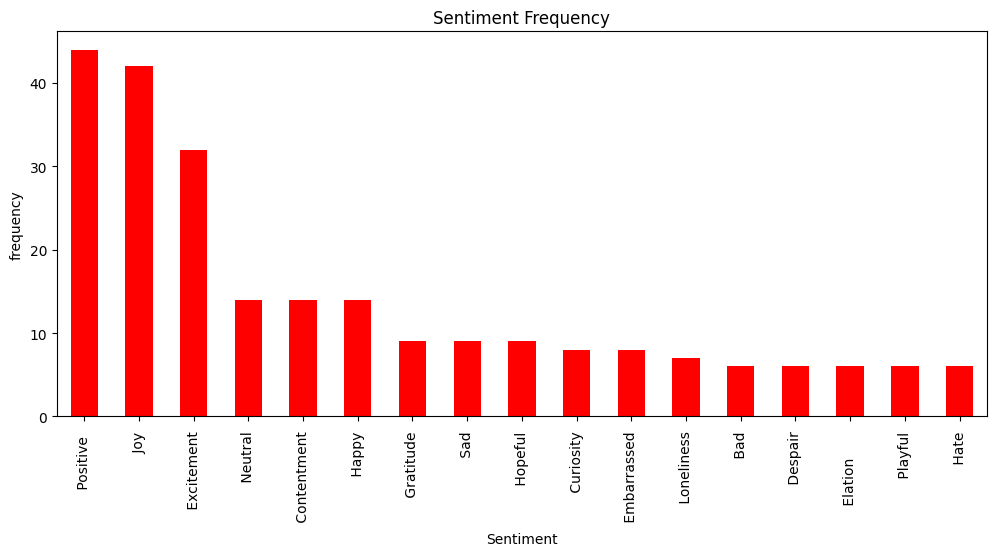

In [185]:
filtered = df['Sentiment'].value_counts()[df['Sentiment'].value_counts() > 5]
filtered.plot(kind='bar', ylabel="frequency", title="Sentiment Frequency", figsize=(12,5), color='red')
plt.show()

_________________________________________________________________________________________________________________________

## Welch’s t-test: Comparing Engagement Between Positive and Negative Posts

In this part, we wanted to see if engagement (likes + retweets) differs between positive and negative posts.
we used the *Welch t-test* because it’s designed to compare the means of two groups that might have
different variances or sample sizes.

*null hypothesis (H0):* there is no difference in average engagement between positive and negative posts.  
*alternative hypothesis (H1):* there is a difference in average engagement between the two groups.

we’ll visualize the averages first and then look at the test results to check if the difference is significant.

Welch t-test: t=9.346, p=0.0000


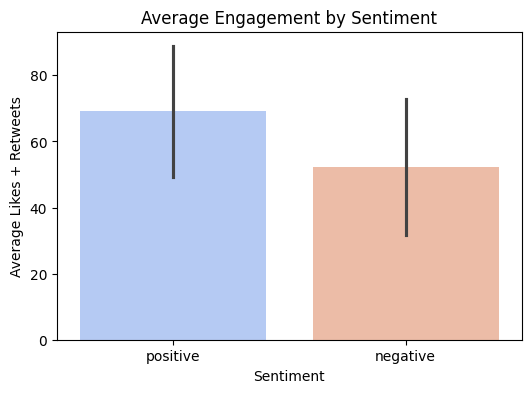

In [186]:
# getting engagement count
engagement = []
for retweet, like in zip(df['Retweets'],  df['Likes']):
    total = like + retweet
    engagement.append(total)

df['Engagement'] = engagement
df


## normalize the labels
df['Sentiment_norm'] = df['Sentiment'].astype(str).str.strip().str.lower()

## put each sentiment into buckets

pos = {
    'positive','happiness','joy','love','amusement','enjoyment','admiration',
    'affection','awe','surprise','acceptance','adoration','anticipation',
    'kind','pride','excitement','optimistic','gratitude'
}

neg = {
    'negative','anger','fear','sadness','disgust','disappointed','bitter',
    'shame'
}

neu = {'neutral', 'confusion','acceptance','calmness'}

sentiment_map = {}
sentiment_map.update({k:'positive' for k in pos})
sentiment_map.update({k:'negative' for k in neg})
sentiment_map.update({k:'netrual' for k in neu})

df['Polarity'] = df['Sentiment_norm'].map(sentiment_map)

## for sentiments that are not mapped, use vader on the text
sia = SentimentIntensityAnalyzer()
def vader_bucket(text):
    c = sia.polarity_scores(str(text))['compound']
    return 'positive' if c > 0.05 else ('negative' if c < -0.05 else 'neutral')

df.loc[df['Polarity'].isna(), 'Polarity'] = df.loc[df['Polarity'].isna(), 'Text'].apply(vader_bucket)

## keep groups with atleast 5 tweets
counts = df['Polarity'].value_counts()
keep = counts[counts >=  5].index
df_f = df[df['Polarity'].isin(keep)]

## compare the means
pos_eng = df_f.loc[df_f['Polarity'] == 'positive', 'Engagement']
neg_eng = df_f.loc[df_f['Polarity'] == 'negative', 'Engagement']

t_stat, p_val = ttest_ind(pos_eng, neg_eng, equal_var=False)

print("Welch t-test: t=%.3f, p=%.4f" % (t_stat, p_val))

df_subset = df_f[df_f['Polarity'].isin(['positive', 'negative'])]

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_subset,
    x='Polarity',
    y='Engagement',
    hue='Polarity',
    legend=False,
    errorbar='sd',
    palette='coolwarm'
)
plt.title('Average Engagement by Sentiment')
plt.ylabel('Average Likes + Retweets')
plt.xlabel('Sentiment')
plt.show()    

The bar chart shows that positive posts have noticeably higher average engagement than negative ones.
Based on the Welch’s t-test that we ran, we found that:

*t = 9.346, p = 0.0000*

Since the p-value < 0.05, we *reject the null hypothesis*.
This means the difference in engagement is statistically significant, positive posts really do get more likes
and retweets than negative ones. this supports our main hypothesis that positive sentiment leads to higher
engagement.

______________________________________________________________________________________________________________________________

## One-Way ANOVA: Comparing Sentiment Across Platforms

In this section, we wanted to see if the average sentiment differs across platforms: twitter, facebook, and instagram.  
Since we’re comparing *three groups, we used a **one-way ANOVA test*.

*null hypothesis (H0):* there is no significant difference in average sentiment between the three platforms.  
*alternative hypothesis (H1):* at least one platform’s average sentiment is significantly different from the others.

We will give each Sentiment a score of either -1 (Negative), 0 (Neutral), or 1 (Positive) based on the emotion. Then we will look at the test results to check if the difference is significant.

In [187]:
# mapping sentiment to scores (-1,0,1) for the hypothesis testing....

sentiment_scores = {
    'Acceptance': 1, 'Accomplishment': 1, 'Admiration': 1, 'Adoration': 1, 'Adrenaline': 1,
    'Adventure': 1, 'Affection': 1, 'Amazement': 1, 'Ambivalence': 0, 'Amusement': 1,
    'Anger': -1, 'Anticipation': 1, 'Anxiety': -1, 'Appreciation': 1, 'Apprehensive': -1,
    'Arousal': 0, 'ArtisticBurst': 1, 'Awe': 1, 'Bad': -1, 'Betrayal': -1, 'Bitter': -1,
    'Bitterness': -1, 'Bittersweet': 0, 'Blessed': 1, 'Boredom': -1, 'Breakthrough': 1,
    'Calmness': 1, 'Captivation': 1, 'Celebration': 1, 'Celestial Wonder': 1, 'Challenge': 0,
    'Charm': 1, 'Colorful': 1, 'Compassion': 1, 'Compassionate': 1, 'Confidence': 1,
    'Confident': 1, 'Confusion': 0, 'Connection': 1, 'Contemplation': 0, 'Contentment': 1,
    'Coziness': 1, 'Creative Inspiration': 1, 'Creativity': 1, 'Culinary Adventure': 1,
    'CulinaryOdyssey': 1, 'Curiosity': 1, 'Darkness': -1, 'Dazzle': 1, 'Desolation': -1,
    'Despair': -1, 'Desperation': -1, 'Determination': 1, 'Devastated': -1,
    'Disappointed': -1, 'Disappointment': -1, 'Disgust': -1, 'Dismissive': -1,
    'DreamChaser': 1, 'Ecstasy': 1, 'Elation': 1, 'Elegance': 1, 'Embarrassed': -1,
    'Emotion': 0, 'EmotionalStorm': -1, 'Empathetic': 1, 'Empowerment': 1, 'Enchantment': 1,
    'Energy': 1, 'Engagement': 1, 'Enjoyment': 1, 'Enthusiasm': 1, 'Envious': -1,
    'Envisioning History': 0, 'Envy': -1, 'Euphoria': 1, 'Excitement': 1, 'Exhaustion': -1,
    'Exploration': 1, 'Fear': -1, 'Fearful': -1, 'FestiveJoy': 1, 'Free-spirited': 1,
    'Freedom': 1, 'Friendship': 1, 'Frustrated': -1, 'Frustration': -1, 'Fulfillment': 1,
    'Grandeur': 1, 'Grateful': 1, 'Gratitude': 1, 'Grief': -1, 'Happiness': 1, 'Happy': 1,
    'Harmony': 1, 'Hate': -1, 'Heartache': -1, 'Heartbreak': -1, 'Heartwarming': 1,
    'Helplessness': -1, 'Hope': 1, 'Hopeful': 1, 'Hypnotic': 0, 'Iconic': 1, 'Imagination': 1,
    'Immersion': 0, 'Indifference': 0, 'InnerJourney': 1, 'Inspiration': 1, 'Inspired': 1,
    'Intimidation': -1, 'Intrigue': 1, 'Isolation': -1, 'Jealous': -1, 'Jealousy': -1,
    'Journey': 1, 'Joy': 1, 'Joy in Baking': 1, 'JoyfulReunion': 1, 'Kind': 1, 'Kindness': 1,
    'Loneliness': -1, 'Loss': -1, 'LostLove': -1, 'Love': 1, 'Marvel': 1, 'Melancholy': -1,
    'Melodic': 1, 'Mesmerizing': 1, 'Mindfulness': 1, 'Miscalculation': -1, 'Mischievous': 0,
    'Motivation': 1, "Nature's Beauty": 1, 'Negative': -1, 'Neutral': 0, 'Nostalgia': 0,
    'Numbness': 0, 'Obstacle': 0, "Ocean's Freedom": 1, 'Optimism': 1, 'Overjoyed': 1,
    'Overwhelmed': -1, 'Pensive': 0, 'Playful': 1, 'PlayfulJoy': 1, 'Positive': 1,
    'Positivity': 1, 'Pressure': -1, 'Pride': 1, 'Proud': 1, 'Radiance': 1, 'Reflection': 0,
    'Regret': -1, 'Rejuvenation': 1, 'Relief': 1, 'Renewed Effort': 1, 'Resentment': -1,
    'Resilience': 1, 'Reverence': 1, 'Romance': 1, 'Ruins': -1, 'Runway Creativity': 1,
    'Sad': -1, 'Sadness': -1, 'Satisfaction': 1, 'Serenity': 1, 'Shame': -1, 'Solace': 1,
    'Solitude': 0, 'Sorrow': -1, 'Spark': 1, 'Success': 1, 'Suffering': -1, 'Surprise': 0,
    'Suspense': 0, 'Sympathy': 1, 'Tenderness': 1, 'Thrill': 1, 'Thrilling Journey': 1,
    'Touched': 1, 'Tranquility': 1, 'Triumph': 1, 'Vibrancy': 1, 'Whimsy': 1,
    'Whispers of the Past': 0, 'Winter Magic': 1, 'Wonder': 1, 'Wonderment': 1, 'Yearning': 0,
    'Zest': 1
}

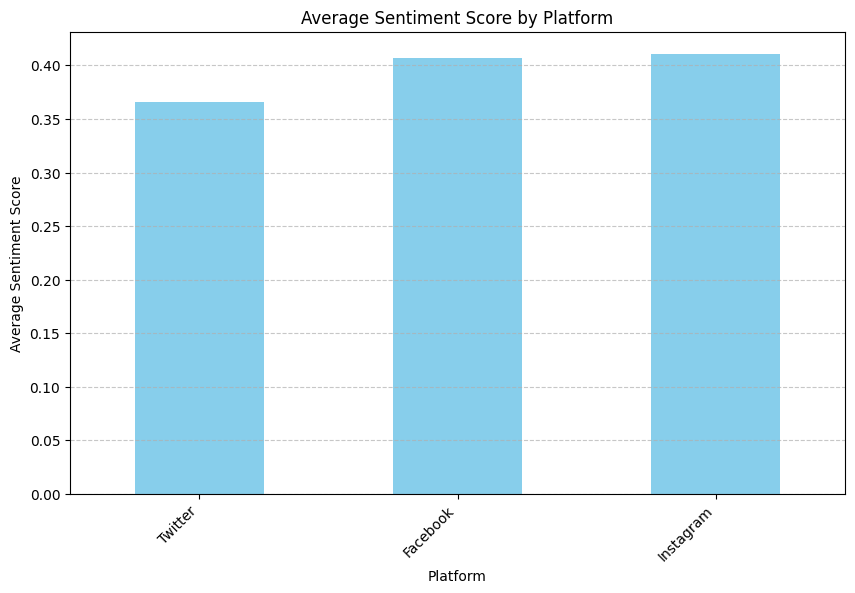

In [ ]:
#Clean sentiment column
df['Platform'] = df['Platform'].str.strip().str.capitalize()
df['Sentiment'] = df['Sentiment'].str.strip()
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_scores)

#Calculates the average sentiment scores per platform
avg_scores = df.groupby('Platform')['Sentiment_Score'].mean().sort_values()

#Creates bar plot
plt.figure(figsize=(10, 6))
avg_scores.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The chart shows that facebook and instagram have slightly higher average sentiment scores than twitter.  
however, when we ran the one-way ANOVA test, we got:

*F-statistic = 1.2153*  
*p-value = 0.303*

since the p-value is greater than 0.05, we *fail to reject the null hypothesis*.  
this means there’s no statistically significant difference in average sentiment across platforms.

in simple words, even though instagram and facebook look a bit more positive, the difference isn’t large enough to be statistically meaningful, all three platforms have pretty similar overall sentiment levels.

In [189]:
df = pd.read_csv("sentimentdataset.csv")

df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower()
df['Platform'] = df['Platform'].astype(str).str.strip().str.title()

# Map to numeric sentiment scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df['Sentiment'] = df['Sentiment'].replace(sentiment_mapping)

# Drop rows with missing or invalid values
df = df.dropna(subset=['Sentiment', 'Platform'])
df = df[df['Sentiment'].isin([-1, 0, 1])]

# Check counts per platform
print("Platforms and counts:")
print(df['Platform'].value_counts(), "\n")

# Group data for ANOVA
groups = [group['Sentiment'].values for _, group in df.groupby('Platform') if len(group) > 1]

# Run one-way ANOVA
if len(groups) >= 2:
    f_stat, p_value = f_oneway(*groups)
    print("ANOVA Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.05:
        print("→ Reject the null hypothesis: At least one platform has a significantly different mean sentiment.")
    else:
        print("Fail to reject the null hypothesis: No significant difference in mean sentiment across platforms.")
else:
    print("Not enough valid groups for ANOVA.")


Platforms and counts:
Platform
Instagram    23
Twitter      22
Facebook     22
Name: count, dtype: int64 

ANOVA Results:
F-statistic: 1.2153
P-value: 0.303363
Fail to reject the null hypothesis: No significant difference in mean sentiment across platforms.
